In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

In [2]:

file_path = r"C:\Users\edoar\Downloads\edoardo.forzano1px0WqJ\CCS_2005010100_2025010100.csv"

df = pd.read_csv(file_path)

df.head()



,Time,Rain(mm)
0,CCS_6h2005010100,0
1,CCS_6h2005010106,0
2,CCS_6h2005010112,0
3,CCS_6h2005010118,0
4,CCS_6h2005010200,0


In [4]:
# Enforce physical bounds
df["rain_mm"] = pd.to_numeric(df["rain_mm"], errors="coerce")
df["rain_mm"] = df["rain_mm"].clip(lower=0)

# Remove numerical noise
df.loc[df["rain_mm"] < 0.1, "rain_mm"] = 0


In [5]:
df["year"] = df["datetime"].dt.year

ams = (
    df.groupby("year")["rain_mm"]
      .max()
      .dropna()
)

ams.head(), len(ams)


(year
 2005    46
 2006    59
 2007    63
 2008    49
 2009    90
 Name: rain_mm, dtype: int64,
 21)

In [11]:
df.sort_values("rain_mm", ascending=False).head(10)

,time_raw,rain_mm,datetime,year
19922,CCS_6h2018082112,143,2018-08-21 12:00:00,2018
18184,CCS_6h2017061300,104,2017-06-13 00:00:00,2017
11084,CCS_6h2012080300,101,2012-08-03 00:00:00,2012
6672,CCS_6h2009072700,90,2009-07-27 00:00:00,2009
28886,CCS_6h2024100912,72,2024-10-09 12:00:00,2024
15547,CCS_6h2015082318,68,2015-08-23 18:00:00,2015
22551,CCS_6h2020060818,68,2020-06-08 18:00:00,2020
18594,CCS_6h2017092312,67,2017-09-23 12:00:00,2017
25724,CCS_6h2022081100,67,2022-08-11 00:00:00,2022
26935,CCS_6h2023060918,66,2023-06-09 18:00:00,2023


In [6]:
shape, loc, scale = genextreme.fit(ams)

shape, loc, scale


(np.float64(0.19014548991526026),
 np.float64(56.93103570415374),
 np.float64(26.189628318733938))

In [7]:
T = 100
prob = 1 - 1 / T

rain_100yr_6h = genextreme.ppf(prob, shape, loc, scale)

rain_100yr_6h


np.float64(137.23199546220434)

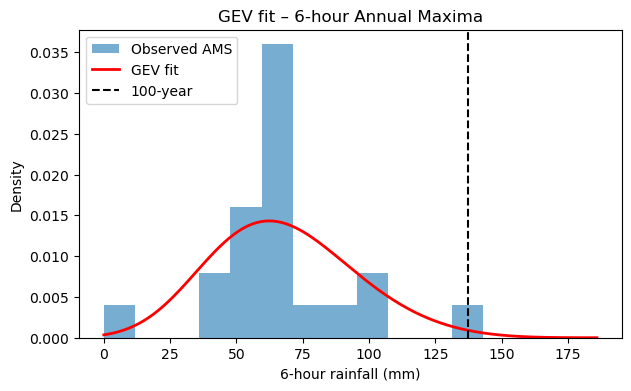

In [8]:
x = np.linspace(0, ams.max() * 1.3, 300)
gev_pdf = genextreme.pdf(x, shape, loc, scale)

plt.figure(figsize=(7,4))
plt.hist(ams, bins=12, density=True, alpha=0.6, label="Observed AMS")
plt.plot(x, gev_pdf, "r", lw=2, label="GEV fit")
plt.axvline(rain_100yr_6h, color="black", linestyle="--", label="100-year")
plt.xlabel("6-hour rainfall (mm)")
plt.ylabel("Density")
plt.title("GEV fit – 6-hour Annual Maxima")
plt.legend()
plt.show()


In [9]:
hyetograph = pd.DataFrame({
    "hour": [1, 2, 3, 4, 5, 6],
    "fraction": [0.25, 0.25, 0.15, 0.15, 0.10, 0.10]
})

hyetograph["rain_mm"] = hyetograph["fraction"] * rain_100yr_6h
hyetograph


,hour,fraction,rain_mm
0,1,0.25,34.307999
1,2,0.25,34.307999
2,3,0.15,20.584799
3,4,0.15,20.584799
4,5,0.10,13.723200
5,6,0.10,13.723200


In [10]:
hyetograph[["hour", "rain_mm"]].to_csv(
    "DAmaturu_HECRAS_100yr_6h_hyetograph.csv",
    index=False
)
